In [9]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import pandas as pd
from scipy.spatial import KDTree

# Function to identify touching cells
def identify_touching_cells(x, y, threshold=0.5):
    points = np.column_stack((x, y))
    tree = KDTree(points)
    pairs = tree.query_pairs(r=threshold)
    return pairs

# Function to find microdomains
def find_microdomains(x, y, radial_cor, threshold=0.9):
    pairs = identify_touching_cells(x, y)
    microdomains = []
    visited = set()
    
    for i in range(len(x)):
        if i in visited or radial_cor[i] <= threshold:
            continue
        stack = [i]
        domain = []
        
        while stack:
            node = stack.pop()
            if node in visited:
                continue
            visited.add(node)
            domain.append(node)
            
            for pair in pairs:
                if node in pair:
                    neighbor = pair[1] if pair[0] == node else pair[0]
                    if neighbor not in visited and radial_cor[neighbor] > threshold:
                        stack.append(neighbor)
        
        if domain:
            microdomains.append(domain)
    
    return microdomains

# Initialize storage for results per aspect ratio
results_per_aspect_ratio = {}
microdomain_decay_results = {}

thickness = 0.1
max_length = 0

# Store time points separately for each aspect ratio pair
aspect_times = {}

for trial in range(1, 6):  # Loop through 5 trials
    trial_path = f"/home/mratman1/activeMatterCommunities/workspace/simulations_eqdivtime/asp10/run{trial}"
    subfolders = [f.path for f in os.scandir(trial_path) if f.is_dir()]

    for subfolder in subfolders:
        filenames = os.listdir(subfolder)
        # Filter out non-CSV files and extract time values from filenames
        csv_files = [f for f in filenames if f.endswith('.csv')]
        if not csv_files:
            continue  # Skip if no CSV files are found

        time_values = sorted([int(f.strip('.csv')) for f in csv_files if f[0].isdigit()])

        # Initialize lists for data
        radial_cor1_list = []
        radial_cor2_list = []

        # Variables to store data for aspect ratio calculation
        asp1_lengths = []
        asp2_lengths = []
        color2_list = []

        for time in time_values:
            df = pd.read_csv(f"{subfolder}/{time}.csv", header=0)
            x, y, ex, ey = df[["x", "y", "ex", "ey"]].T.values
            length, color, color2 = df[["l", "color", "color2"]].T.values

            radialcor1 = []
            radialcor2 = []
            radialcor1_indices = []  # To store original indices for radialcor1
            radialcor2_indices = []  # To store original indices for radialcor2

            # Update color2_list for aspect ratio calculation
            color2_list = color2
            
            for i in range(np.size(x)):
                theta = math.atan2(ey[i], ex[i])
                phi = math.atan2(y[i], x[i])
                if color2[i] == 0:
                    radialcor1.append(np.cos(2 * (theta - phi)))
                    radialcor1_indices.append(i)
                elif color2[i] == 1:
                    radialcor2.append(np.cos(2 * (theta - phi)))
                    radialcor2_indices.append(i)

            avg_radial_cor1 = np.mean(radialcor1) if radialcor1 else np.nan
            avg_radial_cor2 = np.mean(radialcor2) if radialcor2 else np.nan

            radial_cor1_list.append(avg_radial_cor1)
            radial_cor2_list.append(avg_radial_cor2)

            # Identify microdomains for each population
            microdomains1 = find_microdomains(x[color2 == 0], y[color2 == 0], radialcor1)
            microdomains2 = find_microdomains(x[color2 == 1], y[color2 == 1], radialcor2)

            for microdomain in microdomains1:
                radial_orders = [radialcor1[radialcor1_indices.index(i)] for i in microdomain if i in radialcor1_indices]
                avg_order = np.mean(radial_orders) if radial_orders else 0
                
                if avg_order > 0.9:
                    # Calculate aspect ratios
                    asp1_lengths = [length[i] for i in range(len(length)) if color2[i] == 0]
                    asp2_lengths = [length[i] for i in range(len(length)) if color2[i] == 1]

                    Asp_1max = round(max(asp1_lengths) / thickness, 1) if asp1_lengths else 0
                    Asp_2max = round(max(asp2_lengths) / thickness, 1) if asp2_lengths else 0

                    aspect_ratio_key = (Asp_1max, Asp_2max)
                    
                    if aspect_ratio_key not in microdomain_decay_results:
                        microdomain_decay_results[aspect_ratio_key] = []
                    microdomain_decay_results[aspect_ratio_key].append((time, avg_order))

            for microdomain in microdomains2:
                radial_orders = [radialcor2[radialcor2_indices.index(i)] for i in microdomain if i in radialcor2_indices]
                avg_order = np.mean(radial_orders) if radial_orders else 0
                
                if avg_order > 0.9:
                    # Calculate aspect ratios
                    asp1_lengths = [length[i] for i in range(len(length)) if color2[i] == 0]
                    asp2_lengths = [length[i] for i in range(len(length)) if color2[i] == 1]

                    Asp_1max = round(max(asp1_lengths) / thickness, 1) if asp1_lengths else 0
                    Asp_2max = round(max(asp2_lengths) / thickness, 1) if asp2_lengths else 0

                    aspect_ratio_key = (Asp_1max, Asp_2max)
                    
                    if aspect_ratio_key not in microdomain_decay_results:
                        microdomain_decay_results[aspect_ratio_key] = []
                    microdomain_decay_results[aspect_ratio_key].append((time, avg_order))

        # Extend or truncate arrays to match the maximum length
        max_length = max(max_length, len(radial_cor1_list))
        radial_cor1_list += [0] * (max_length - len(radial_cor1_list))
        radial_cor2_list += [0] * (max_length - len(radial_cor2_list))

        # Ensure aspect ratio calculation after each time step
        Asp_1max = round(max(asp1_lengths) / thickness, 1) if asp1_lengths else 0
        Asp_2max = round(max(asp2_lengths) / thickness, 1) if asp2_lengths else 0
        aspect_ratio_key = (Asp_1max, Asp_2max)

        if aspect_ratio_key not in results_per_aspect_ratio:
            results_per_aspect_ratio[aspect_ratio_key] = {
                "radial_cor1": [], "radial_cor2": [], "times": []
            }
        results_per_aspect_ratio[aspect_ratio_key]["radial_cor1"].append(radial_cor1_list)
        results_per_aspect_ratio[aspect_ratio_key]["radial_cor2"].append(radial_cor2_list)
        results_per_aspect_ratio[aspect_ratio_key]["times"].append(time_values)

# Calculate the time at which the radial order falls below 0.9
microdomain_decay_times_below_threshold = {}

for key, time_orders in microdomain_decay_results.items():
    found_below_threshold = False
    for time, order in time_orders:
        if order < 0.9:
            microdomain_decay_times_below_threshold[key] = time
            found_below_threshold = True
            break
    if not found_below_threshold:
        microdomain_decay_times_below_threshold[key] = np.nan  # Assign NaN if never falls below 0.9

# Display the times at which radial order falls below 0.9
print("Times at which Radial Order Falls Below 0.9:")
for key, decay_time in microdomain_decay_times_below_threshold.items():
    print(f"Aspect Ratio {key}: Time = {decay_time if not np.isnan(decay_time) else 'Never fell below 0.9'}")

# Plotting (adapt as needed based on your requirements)
plt.figure(figsize=(12, 6))

# Select a few aspect ratios to plot
example_aspect_ratios = list(microdomain_decay_results.keys())[:3]  # Select up to 3 aspect ratios

for aspect_ratio_key in example_aspect_ratios:
    times, orders = zip(*microdomain_decay_results[aspect_ratio_key])
    plt.plot(times, orders, label=f'Aspect Ratio {aspect_ratio_key}', marker='o')

plt.xlabel('Time')
plt.ylabel('Radial Order')
plt.title('Radial Order vs. Time for Selected Aspect Ratios')
plt.legend()
plt.grid(True)
plt.show()


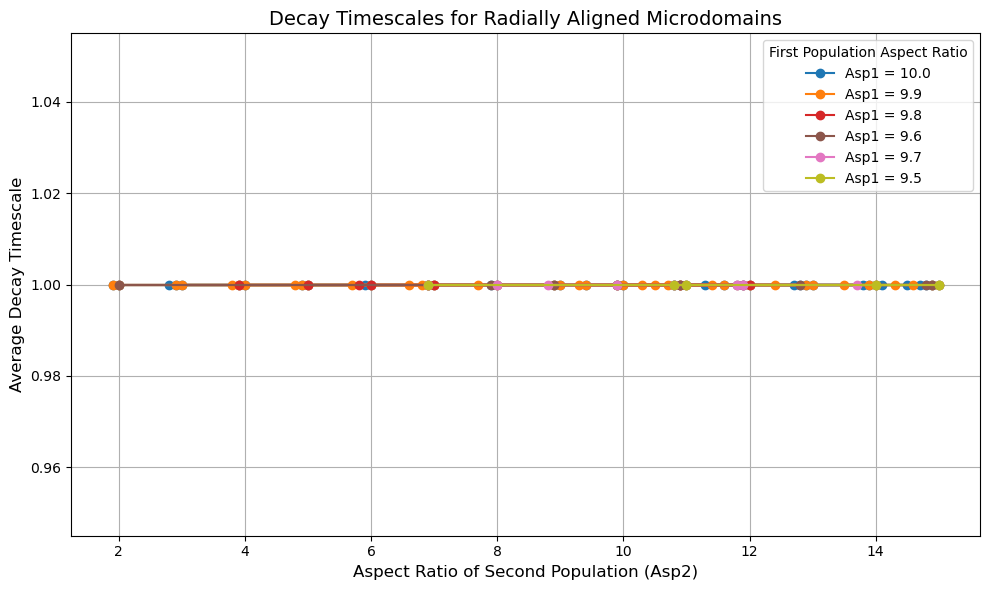

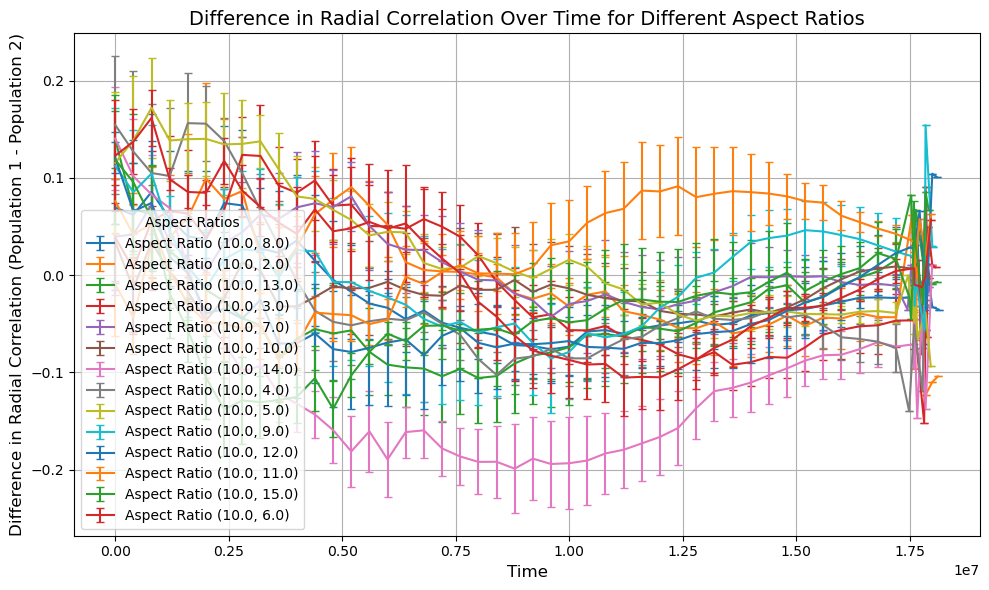

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot decay timescales for radially aligned microdomains
def plot_decay_timescales(microdomain_decay_timescales):
    # Create a dictionary to store decay timescales by first aspect ratio
    decay_timescales_by_aspect1 = {}

    # Organize the decay timescales by the first aspect ratio
    for (asp1, asp2), timescale in microdomain_decay_timescales.items():
        if asp1 not in decay_timescales_by_aspect1:
            decay_timescales_by_aspect1[asp1] = {'asp2': [], 'timescale': []}
        decay_timescales_by_aspect1[asp1]['asp2'].append(asp2)
        decay_timescales_by_aspect1[asp1]['timescale'].append(timescale)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create a color map for different first aspect ratios
    color_map = plt.get_cmap('tab10')  # You can use any colormap you prefer

    for idx, (asp1, data) in enumerate(decay_timescales_by_aspect1.items()):
        asp2_values = data['asp2']
        timescale_values = data['timescale']
        
        # Plot each first aspect ratio with a different color
        color = color_map(idx / len(decay_timescales_by_aspect1))
        ax.plot(asp2_values, timescale_values, marker='o', linestyle='-', color=color, label=f'Asp1 = {asp1}')

    # Customize the plot
    ax.set_xlabel('Aspect Ratio of Second Population (Asp2)', fontsize=12)
    ax.set_ylabel('Average Decay Timescale', fontsize=12)
    ax.set_title('Decay Timescales for Radially Aligned Microdomains', fontsize=14)
    ax.legend(title='First Population Aspect Ratio')
    ax.grid(True)

    plt.tight_layout()
    plt.show()

# Function to plot difference in radial correlations over time with error bars
def plot_radial_correlation_difference(averaged_results):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for key, data in averaged_results.items():
        times = data["times"]
        avg_diff_radial_cor = data["avg_diff_radial_cor"]
        sem_diff_radial_cor = data["sem_diff_radial_cor"]
        
        # Plot with error bars
        ax.errorbar(times, avg_diff_radial_cor, yerr=sem_diff_radial_cor, label=f'Aspect Ratio {key}', capsize=3)
    
    # Customize the plot
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Difference in Radial Correlation (Population 1 - Population 2)', fontsize=12)
    ax.set_title('Difference in Radial Correlation Over Time for Different Aspect Ratios', fontsize=14)
    ax.legend(title='Aspect Ratios')
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Example call to the plotting functions with the calculated results
plot_decay_timescales(microdomain_decay_timescales)
plot_radial_correlation_difference(averaged_results)


Aspect Ratios: (10.0, 8.0), Decay Timescale: 1.0
Aspect Ratios: (10.0, 7.0), Decay Timescale: 1.0
Aspect Ratios: (10.0, 2.0), Decay Timescale: 1.0
Aspect Ratios: (10.0, 13.0), Decay Timescale: 1.0
Aspect Ratios: (10.0, 12.0), Decay Timescale: 1.0
Aspect Ratios: (10.0, 3.0), Decay Timescale: 1.0
Aspect Ratios: (10.0, 9.0), Decay Timescale: 1.0
Aspect Ratios: (10.0, 10.0), Decay Timescale: 1.0
Aspect Ratios: (10.0, 14.0), Decay Timescale: 1.0
Aspect Ratios: (10.0, 4.0), Decay Timescale: 1.0
Aspect Ratios: (10.0, 5.0), Decay Timescale: 1.0
Aspect Ratios: (10.0, 11.0), Decay Timescale: 1.0
Aspect Ratios: (10.0, 15.0), Decay Timescale: 1.0
Aspect Ratios: (10.0, 6.0), Decay Timescale: 1.0


NameError: name 'asp2_values' is not defined